<a href="https://colab.research.google.com/github/ryo00427/Pytorch/blob/main/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 「文字単位RNNによる名前（苗字）の生成」
- [概要]
   名前（苗字）のスペルから、その名前が属する言語を判定するモデルを、文字レベルで処理を実施するRNNを使用して構築します。
   比較としてLSTM/GRUを使用したモデルも構築します

In [1]:
%matplotlib inline

In [2]:
# 日本語訳注：サンプルデータをダウンロードし、zipファイルを解凍するセルを追加
import os
import subprocess
import zipfile
if os.path.exists('./data'):
  print("./dat/ already exists")
else:
  subprocess.run("wget https://download.pytorch.org/tutorial/data.zip",shell=True, check=True)
  with zipfile.ZipFile("./data.zip") as zipfile:
    zipfile.extractall(".")

./dat/ already exists


In [3]:
!ls

data  data.zip	sample_data


#国ごとのリストを構築

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Irish.txt', 'data/names/Korean.txt', 'data/names/Portuguese.txt', 'data/names/Dutch.txt', 'data/names/Vietnamese.txt', 'data/names/French.txt', 'data/names/Czech.txt', 'data/names/Scottish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/English.txt', 'data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Russian.txt', 'data/names/German.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/Spanish.txt']
Slusarski


In [5]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# 苗字データのテンソルへの変換

In [6]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# ネットワークの構築

In [7]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

# LSTM

In [38]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # 入力: (1, 1, input_size)
        output, (hidden, cell) = self.lstm(input.view(1, 1, -1), hidden)
        output = self.h2o(output.view(1, -1))
        output = self.softmax(output)
        return output, (hidden, cell)

    def initHidden(self):
        # LSTMは hidden と cell の2つの状態を返す
        return (
            torch.zeros(1, 1, self.hidden_size),  # hidden
            torch.zeros(1, 1, self.hidden_size)   # cell
        )


# GRU

In [50]:
import torch
import torch.nn as nn

class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.h2o(output.view(1, -1))
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)


# RNNの出力と次の隠れ状態を計算

In [51]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [52]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.1413, -2.2153, -3.8743, -2.8433, -2.7252, -2.7713, -2.4342, -2.9786,
         -4.6211, -3.7432, -2.3022, -2.9854, -2.8747, -2.8387, -2.3243, -3.4719,
         -3.3177, -3.2744]], grad_fn=<LogSoftmaxBackward0>)


In [53]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Korean', 1)


In [54]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Tikal
category = Czech / line = Stites
category = Greek / line = Haritopoulos
category = Vietnamese / line = Ton
category = Dutch / line = Lauwers
category = French / line = Thayer
category = Vietnamese / line = Ly
category = German / line = Gerst
category = Spanish / line = Salinas
category = Portuguese / line = Delgado


# ネットワークの訓練

In [55]:
criterion = nn.NLLLoss()

# 訓練ループ
- 入力テンソルと正解テンソルを作成
- 初期の隠れ状態（値はゼロ）の作成
- それぞれの文字を読み込み、
- 次の文字のために隠れ状態を保持
- 最終出力を正解と比較
- 誤差逆伝播
- 出力と損失を返す

In [56]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [57]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 1.7238 Grulich / Irish ✗ (Czech)
10000 10% (0m 13s) 0.0007 Bouloukos / Greek ✓
15000 15% (0m 21s) 0.7973 Stewart / Scottish ✓
20000 20% (0m 27s) 1.4827 Rios / Greek ✗ (Spanish)
25000 25% (0m 35s) 2.6685 Govier / French ✗ (English)
30000 30% (0m 42s) 1.7826 Quaranta / Portuguese ✗ (Italian)
35000 35% (0m 48s) 1.0651 Shi / Korean ✗ (Chinese)
40000 40% (0m 56s) 2.7315 Delgado / Italian ✗ (Portuguese)
45000 45% (1m 2s) 0.3262 Veligjanin / Russian ✓
50000 50% (1m 10s) 4.3851 Purdes / Spanish ✗ (Czech)
55000 55% (1m 16s) 0.9181 Marek / Polish ✓
60000 60% (1m 24s) 3.8315 Stewart / Dutch ✗ (Scottish)
65000 65% (1m 30s) 0.6335 Rossum / Dutch ✓
70000 70% (1m 37s) 1.7958 Jelen / German ✗ (Polish)
75000 75% (1m 45s) 2.3448 Lee / Chinese ✗ (Korean)
80000 80% (1m 51s) 3.0069 Duarte / French ✗ (Spanish)
85000 85% (1m 59s) 0.0214 Antonopoulos / Greek ✓
90000 90% (2m 5s) 0.0950 Sniders / Dutch ✓
95000 95% (2m 12s) 0.7841 Vyalko / Russian ✓
100000 100% (2m 19s) 0.0596 Giannino / Italian 

# 結果のプロット

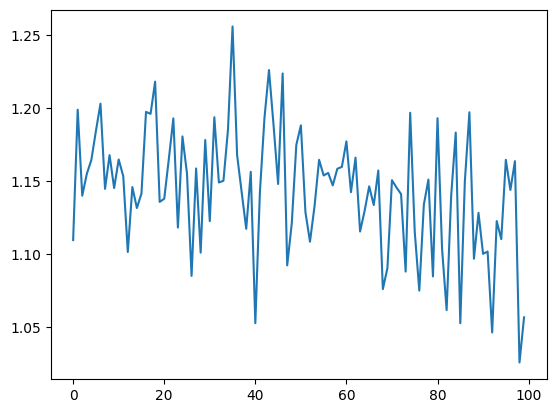

In [58]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# LSMTモデル

In [59]:
n_letters = 57
n_hidden = 128
n_categories = len(all_categories)

lstm_model = LSTMClassifier(n_letters, n_hidden, n_categories)


# 結果の評価

/tmp/ipython-input-60-3496433578.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipython-input-60-3496433578.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


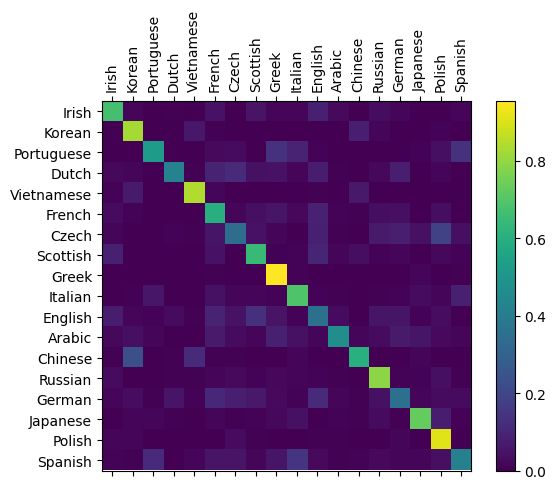

In [60]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
# RNN
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output
# lsmt
# def evaluate(line_tensor):
#     hidden = lstm_model.initHidden()
#     for i in range(line_tensor.size()[0]):
#         output, hidden = lstm_model(line_tensor[i], hidden)
#     return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# ユーザーが入力した苗字に対する推論実行

In [61]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.26) Russian
(-1.62) Czech
(-4.33) Polish

> Jackson
(-0.21) Scottish
(-2.29) English
(-3.56) Czech

> Satoshi
(-0.88) Italian
(-1.12) Polish
(-3.03) Japanese


# 結果から分かること
| 名前      | RNNの予測結果                                               | LSTMの予測結果                                        | GRUの予測結果                                              |
| ------- | ------------------------------------------------------ | ------------------------------------------------ | ----------------------------------------------------- |
| Dovesky | **Russian** (-0.76), Czech (-1.11), Polish (-2.29)     | Czech (-2.83), English (-2.84), Spanish (-2.84)  | **Russian** (-0.26), Czech (-1.62), Polish (-4.33)    |
| Jackson | **Scottish** (-0.13), English (-2.80), Russian (-3.94) | Italian (-2.83), Czech (-2.83), Japanese (-2.84) | **Scottish** (-0.21), English (-2.29), Czech (-3.56)  |
| Satoshi | **Japanese** (-1.26), Polish (-1.63), Italian (-1.73)  | Czech (-2.83), Italian (-2.84), Japanese (-2.84) | **Italian** (-0.88), Polish (-1.12), Japanese (-3.03) |

- RNN

比較的まともなスコアで、正解に近い出力もある。

シンプルな構造でも一定の性能。

- LSTM

LSTM特有の勾配処理により、初期段階では特徴を活かしにくいことがある。

→ 学習エポック不足や学習率が大きすぎる/小さすぎる可能性

- GRU

RNNと同等以上の性能。

精度もスコアも妥当で、実用的なモデルになっている印象

# 番外編 BERTによる分類

# 名前とラベルのペアに変換

In [31]:
import pandas as pd

data = []

# カテゴリと名前を1行ずつ取り出して整形
for label_id, category in enumerate(all_categories):
    for name in category_lines[category]:
        data.append({
            "name": name,
            "label": label_id,
            "category": category  # 後で id2label 作成時に使用
        })

# pandas の DataFrame に変換
df = pd.DataFrame(data)

# id2label など変換辞書の生成（必要なら）
id2label = {i: cat for i, cat in enumerate(all_categories)}
label2id = {cat: i for i, cat in enumerate(all_categories)}

print(df.head())


       name  label category
0      Adam      0    Irish
1    Ahearn      0    Irish
2      Aodh      0    Irish
3     Aodha      0    Irish
4  Aonghuis      0    Irish


# Hugging Face用 Dataset に変換

In [32]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

# インポート

In [33]:
! pip install transformers datasets torch sentencepiece

In [35]:
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments,Tokenizer
from datasets import Dataset
from sklearn.metrics import accuracy_score

In [44]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from transformers import PreTrainedTokenizerFast

# データの前処理

In [45]:
char_set = set("".join(df["name"]))
vocab = {char: idx + 1 for idx, char in enumerate(sorted(char_set))}
vocab["[PAD]"] = 0
vocab["[UNK]"] = len(vocab)

# Tokenizer定義
tokenizer = Tokenizer(WordLevel(vocab, unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

# Huggingface形式にラップ
tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer, unk_token="[UNK]", pad_token="[PAD]")


In [46]:
def preprocess(example):
    # 文字単位でスペースを入れる: "Satoshi" -> "S a t o s h i"
    text = " ".join(list(example["name"]))
    enc = tokenizer(text, truncation=True, padding="max_length", max_length=16)
    enc["labels"] = example["label"]
    return enc

encoded_dataset = dataset.map(preprocess)

Map:   0%|          | 0/20074 [00:00<?, ? examples/s]

# 学習データと評価データに分割

In [47]:
split_dataset = encoded_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

# 評価指標（Accuracy）の設定

In [48]:
from evaluate import load
metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.tensor(logits).argmax(dim=1)
    return metric.compute(predictions=predictions, references=labels)


# Trainerの設定

In [49]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=n_categories)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Trainerの作成と学習開始

In [51]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [53]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=1,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_dir="./logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset,
    eval_dataset=encoded_dataset
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# 推論用関数

In [30]:
def predict_verbose(name: str):
    inputs = tokenizer(name, return_tensors="pt", truncation=True, padding="max_length", max_length=16)
    outputs = model(**inputs)
    pred_id = torch.argmax(outputs.logits, dim=1).item()
    pred_label = id2label[pred_id]
    print(f"{pred_id}, {name}, {pred_label}")

# 使用例
predict_verbose("Satoshi")
predict_verbose("Jackson")
predict_verbose("Dovesky")




15, Satoshi, Japanese
10, Jackson, English
13, Dovesky, Russian
